# What is the notebook about?

## Problem - Gridworld Environment Algorithms
This problem deals with a grid world and stochastic actions. The tasks you have to do are:
- Implement Policy Iteration
- Implement Value Iteration
- Implement TD lamdda
- Visualize the results
- Explain the results

## How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved.**You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data. This should be an absolute path.
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [1]:
!pip install aicrowd-cli > /dev/null 

ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


# AIcrowd Runtime Configuration 🧷

Get login API key from https://www.aicrowd.com/participants/me

In [2]:
import os

AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/a5562c7d-55f0-4d06-841c-110655bb04ec_a2_gridworld_inputs.zip")
AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")


API Key valid
Saved API Key successfully!
a5562c7d-55f0-4d06-841c-110655bb04ec_a2_gridworld_inputs.zip: 100% 14.2k/14.2k [00:00<00:00, 591kB/s]


In [4]:
!unzip -q $AICROWD_DATASET_PATH

In [5]:
DATASET_DIR = 'inputs/'

# GridWorld Environment
Read the code for the environment thoroughly

Do not edit the code for the environment

In [6]:
import numpy as np

class GridEnv_HW2:
    def __init__(self, 
                 goal_location, 
                 action_stochasticity,
                 non_terminal_reward,
                 terminal_reward,
                 grey_in,
                 brown_in,
                 grey_out,
                 brown_out
                ):

        # Do not edit this section 
        self.action_stochasticity = action_stochasticity
        self.non_terminal_reward = non_terminal_reward
        self.terminal_reward = terminal_reward
        self.grid_size = [10, 10]

        # Index of the actions 
        self.actions = {'N': (1, 0), 
                        'E': (0,1),
                        'S': (-1,0), 
                        'W': (0,-1)}
        
        self.perpendicular_order = ['N', 'E', 'S', 'W']
        
        l = ['normal' for _ in range(self.grid_size[0]) ]
        self.grid = np.array([l for _ in range(self.grid_size[1]) ], dtype=object)

        self.grid[goal_location[0], goal_location[1]] = 'goal'
        self.goal_location = goal_location

        for gi in grey_in:
            self.grid[gi[0],gi[1]] = 'grey_in'
        for bi in brown_in:    
            self.grid[bi[0], bi[1]] = 'brown_in'

        for go in grey_out:    
            self.grid[go[0], go[1]] = 'grey_out'
        for bo in brown_out:    
            self.grid[bo[0], bo[1]] = 'brown_out'

        self.grey_outs = grey_out
        self.brown_outs = brown_out

    def _out_of_grid(self, state):
        if state[0] < 0 or state[1] < 0:
            return True
        elif state[0] > self.grid_size[0] - 1:
            return True
        elif state[1] > self.grid_size[1] - 1:
            return True
        else:
            return False

    def _grid_state(self, state):
        return self.grid[state[0], state[1]]        
        
    def get_transition_probabilites_and_reward(self, state, action):
        """ 
        Returns the probabiltity of all possible transitions for the given action in the form:
        A list of tuples of (next_state, probability, reward)
        Note that based on number of state and action there can be many different next states
        Unless the state is All the probabilities of next states should add up to 1
        """

        grid_state = self._grid_state(state)
        
        if grid_state == 'goal':
            return [(self.goal_location, 1.0, 0.0)]
        elif grid_state == 'grey_in':
            npr = []
            for go in self.grey_outs:
                npr.append((go, 1/len(self.grey_outs), 
                            self.non_terminal_reward))
            return npr
        elif grid_state == 'brown_in':
            npr = []
            for bo in self.brown_outs:
                npr.append((bo, 1/len(self.brown_outs), 
                            self.non_terminal_reward))
            return npr
        
        direction = self.actions.get(action, None)
        if direction is None:
            raise ValueError("Invalid action %s , please select among" % action, list(self.actions.keys()))

        dir_index = self.perpendicular_order.index(action)
        wrap_acts = self.perpendicular_order[dir_index:] + self.perpendicular_order[:dir_index]
        next_state_probs = {}
        for prob, a in zip(self.action_stochasticity, wrap_acts):
            d = self.actions[a]
            next_state = (state[0] + d[0]), (state[1] + d[1])
            if self._out_of_grid(next_state):
                next_state = state
            next_state_probs.setdefault(next_state, 0.0)
            next_state_probs[next_state] += prob

        npr = []
        for ns, prob in next_state_probs.items():
            next_grid_state = self._grid_state(ns)
            reward = self.terminal_reward if next_grid_state == 'goal' else self.non_terminal_reward
            npr.append((ns, prob, reward))

        return npr

    def step(self, state, action):
        npr = self.get_transition_probabilites_and_reward(state, action)
        probs = [t[1] for t in npr]
        sampled_idx = np.random.choice(range(len(npr)), p=probs)
        sampled_npr = npr[sampled_idx]
        next_state = sampled_npr[0]
        reward = sampled_npr[2]
        is_terminal = next_state == tuple(self.goal_location)
        return next_state, reward, is_terminal

## Example environment

This has the same setup as the pdf, do not edit the settings

In [7]:
def get_base_kwargs():
    goal_location = (9,9)
    action_stochasticity = [0.8, 0.2/3, 0.2/3, 0.2/3]
    grey_out = [(3,2), (4,2), (5,2), (6,2)]
    brown_in = [(9,7)]
    grey_in = [(0,0)]
    brown_out = [(1,7)]
    non_terminal_reward = 0
    terminal_reward = 10

    base_kwargs =  {"goal_location": goal_location, 
            "action_stochasticity": action_stochasticity,
            "brown_in": brown_in, 
            "grey_in": grey_in, 
            "brown_out": brown_out,
            "non_terminal_reward": non_terminal_reward,
            "terminal_reward": terminal_reward,
            "grey_out": grey_out,}
    
    return base_kwargs

base_kwargs = get_base_kwargs()

## Task 2.1 - Value Iteration
Run value iteration on the environment and generate the policy and expected reward

In [11]:
def value_iteration(env, gamma):
    # Initial Values
    values = np.zeros((10, 10))
    list_values = []
    # Initial policy
    policy = np.empty((10, 10), object)
    policy[:] = 'N' # Make all the policy values as 'N'
    n_steps = 0
    # Begin code here
    while True :
      n_steps += 1
      list_values.append(values.copy())
      delta = 0
      new_policy = policy.copy()
      new_values = values.copy()

      for i in range(10) :
        for j in range(10) :
          ####### Calculate the updated value ad policy ###########

          possible_actions = env.actions 
          action_value_dict = {}
          for action in possible_actions :
            temp = 0
            nextstate_prob_rewards = env.get_transition_probabilites_and_reward((i,j),action)
            for ns,prob,reward in nextstate_prob_rewards :
              temp = temp + prob*( reward + gamma * values[ns] )
            action_value_dict[action] = temp
          
          new_policy[i,j] = max(action_value_dict,key = action_value_dict.get)
          new_values[i,j] = action_value_dict[new_policy[i,j]]
          delta = max([ delta , np.abs(new_values[i,j] - values[i,j] ) ])
      
      policy = new_policy.copy()
      values = new_values.copy()
      if delta < 1e-8 :
        break

    # Put your extra information needed for plots etc in this dictionary
    extra_info = {'Steps':n_steps,'Values_list':list_values}

    # End code

    # Do not change the number of output values
    return {"Values": values, "Policy": policy}, extra_info

In [12]:
env = GridEnv_HW2(**base_kwargs)
result_value_iteration, extra_info_vi = value_iteration(env, 0.7)

 # The rounding off is just for making print statement cleaner
print(np.flipud(np.round(result_value_iteration['Values'], decimals=2)))
print(np.flipud(result_value_iteration['Policy']))
print('Steps : ',extra_info_vi['Steps'])

[[0.1  0.15 0.24 0.37 0.56 0.86 1.29 0.12 8.68 0.  ]
 [0.13 0.2  0.31 0.5  0.81 1.31 2.12 3.43 5.75 8.95]
 [0.1  0.16 0.25 0.39 0.62 0.97 1.52 2.38 3.7  5.61]
 [0.07 0.11 0.17 0.26 0.41 0.64 0.99 1.54 2.38 3.52]
 [0.05 0.07 0.11 0.17 0.27 0.41 0.64 0.99 1.53 2.21]
 [0.03 0.05 0.07 0.11 0.17 0.27 0.41 0.64 0.98 1.39]
 [0.02 0.03 0.05 0.07 0.11 0.17 0.27 0.41 0.63 0.87]
 [0.03 0.02 0.03 0.05 0.07 0.11 0.17 0.27 0.4  0.55]
 [0.04 0.03 0.02 0.03 0.05 0.07 0.11 0.17 0.26 0.35]
 [0.07 0.04 0.03 0.02 0.03 0.05 0.07 0.11 0.17 0.22]]
[['E' 'E' 'E' 'E' 'E' 'S' 'S' 'N' 'E' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'N']
 ['N' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'N' 'N']
 ['N' 'E' 'E' 'E' 'E' 'E' 'N' 'N' 'N' 'N']
 ['N' 'N' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'N']
 ['S' 'N' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'N']
 ['S' 'S' 'E' 'E' 'E' 'E' 'N' 'N' 'N' 'N']
 ['N' 'W' 'W' 'E' 'E' 'E' 'E' 'N' 'N' 'N']]
Steps :  40


## Task 2.2 - Policy Iteration
Run policy iteration on the environment and generate the policy and expected reward

In [28]:
def policy_iteration(env, gamma):
    # Initial Values
    values = np.zeros((10, 10))

    # Initial policy
    policy = np.empty((10, 10), object)
    policy[:] = 'N' # Make all the policy values as 'N'

    # Begin code here
    list_values = []
    n_steps = 0
    while True :
      n_steps += 1
      list_values.append(values.copy())
      ################# policy evaluation ####################
      while True :
        delta = 0

        for i in range(10):
          for j in range(10):

            values_prev = values.copy()
            temp = 0

            next_prob_states = env.get_transition_probabilites_and_reward((i,j),policy[i,j])
            for ns,prob,reward in next_prob_states :
              temp = temp + prob*( reward + gamma * values[ns] )
            
            values[i,j] = temp

            delta = max( [ delta , np.abs( values[i,j] - values_prev[i,j] ) ] )
        
        if delta < 1e-8 :
          break
      
      ################### policy improvement ################
      done = 1

      for i in range(10):
        for j in range(10):

          policy_prev = policy.copy()
          action_dict = {}

          for action in env.actions :
            temp = 0

            next_prob_states = env.get_transition_probabilites_and_reward((i,j),action)
            for ns,prob,reward in next_prob_states :
              temp = temp + prob*( reward + gamma * values[ns] )
            action_dict[action] = temp

          policy[i,j] = max( action_dict , key=action_dict.get )

          if policy_prev[i,j] != policy[i,j] :
            done = 0
      
      if done == 1 :
        break

    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {'Steps' : n_steps,'Values_list':list_values}

    # End code

    # Do not change the number of output values
    return {"Values": values, "Policy": policy}, extra_info

In [29]:
env = GridEnv_HW2(**base_kwargs)
result_pi, extra_info_pi = policy_iteration(env, 0.7)

 # The rounding off is just for making print statement cleaner
print(np.flipud(np.round(result_pi['Values'], decimals=2)))
print(np.flipud(result_pi['Policy']))
print('Steps : ',extra_info_pi['Steps'])

[[0.1  0.15 0.24 0.37 0.56 0.86 1.29 0.12 8.68 0.  ]
 [0.13 0.2  0.31 0.5  0.81 1.31 2.12 3.43 5.75 8.95]
 [0.1  0.16 0.25 0.39 0.62 0.97 1.52 2.38 3.7  5.61]
 [0.07 0.11 0.17 0.26 0.41 0.64 0.99 1.54 2.38 3.52]
 [0.05 0.07 0.11 0.17 0.27 0.41 0.64 0.99 1.53 2.21]
 [0.03 0.05 0.07 0.11 0.17 0.27 0.41 0.64 0.98 1.39]
 [0.02 0.03 0.05 0.07 0.11 0.17 0.27 0.41 0.63 0.87]
 [0.03 0.02 0.03 0.05 0.07 0.11 0.17 0.27 0.4  0.55]
 [0.04 0.03 0.02 0.03 0.05 0.07 0.11 0.17 0.26 0.35]
 [0.07 0.04 0.03 0.02 0.03 0.05 0.07 0.11 0.17 0.22]]
[['E' 'E' 'E' 'E' 'E' 'S' 'S' 'N' 'E' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'N']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'N']
 ['N' 'E' 'E' 'E' 'E' 'E' 'E' 'N' 'N' 'N']
 ['N' 'E' 'E' 'E' 'E' 'E' 'N' 'N' 'N' 'N']
 ['N' 'N' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'N']
 ['S' 'N' 'E' 'E' 'E' 'N' 'N' 'N' 'N' 'N']
 ['S' 'S' 'E' 'E' 'E' 'E' 'N' 'N' 'N' 'N']
 ['N' 'W' 'W' 'E' 'E' 'E' 'E' 'N' 'N' 'N']]
Steps :  6


# Task 2.3 - TD Lambda

Use the heuristic policy and implement TD lambda to find values on the gridworld

In [15]:
# The policy mentioned in the pdf to be used for TD lambda, do not modify this
def heuristic_policy(env, state):
    goal = env.goal_location
    dx = goal[0] - state[0]
    dy = goal[1] - state[1]
    if abs(dx) >= abs(dy):
        direction = (np.sign(dx), 0)
    else:
        direction = (0, np.sign(dy))
    for action, dir_val in env.actions.items():
        if dir_val == direction:
            target_action = action
            break
    return target_action

In [47]:
def td_lambda(env, lamda, seeds):
    alpha = 0.5
    gamma = 0.7
    N = len(seeds)
    # Usage of input_policy
    # heuristic_policy(env, state) -> action
    example_action = heuristic_policy(env, (1,2)) # Returns 'N' if goal is (9,9)

    # Example of env.step
    # env.step(state, action) -> Returns next_state, reward, is_terminal

    # Initial values
    values = np.zeros((10, 10))
    es = np.zeros((10,10))

    list_values = []
    for episode_idx in range(N):
         # Do not change this else the results will not match due to environment stochas
        np.random.seed(seeds[episode_idx])
        
        grey_in_loc = np.where(env.grid == 'grey_in')
        state = grey_in_loc[0][0], grey_in_loc[1][0]
        done = False
        while not done:
            action = heuristic_policy(env, state)
            ns, rew, is_terminal = env.step(state, action) 
            # env.step is already taken inside the loop for you, 
            # Don't use env.step anywhere else in your code
            
            # Begin code here
            d = rew + gamma * values[ns] - values[state]
            es[state] = es[state] + 1

            for i in range(10) :
              for j in range(10) :
                values[i,j] = values[i,j] + alpha * d * es[i,j]
                es[i,j] = gamma * lamda * es[i,j]

            state = ns
            if state[0] == np.where(env.grid == 'goal')[0][0] and state[1] == np.where(env.grid == 'goal')[1][0] :
              done = True
        list_values.append(values.copy())
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {'Values_list':list_values}

    # End code

    # Do not change the number of output values
    return {"Values": values}, extra_info

In [49]:
env = GridEnv_HW2(**base_kwargs)
res, extra_info = td_lambda(env, lamda=0.5, seeds=np.arange(1000))

 # The rounding off is just for making print statement cleaner
print(np.flipud(np.round(res['Values'], decimals=3)))

[[0.0000e+00 0.0000e+00 7.0000e-03 1.9000e-02 3.5000e-02 6.0000e-02
  8.3000e-02 1.0500e-01 1.0005e+01 0.0000e+00]
 [0.0000e+00 0.0000e+00 4.1000e-02 1.7900e-01 9.1300e-01 1.4020e+00
  1.2800e+00 4.8500e+00 6.9800e+00 9.9230e+00]
 [0.0000e+00 5.2000e-02 2.4200e-01 4.2200e-01 6.2600e-01 7.1200e-01
  2.0830e+00 3.2850e+00 3.7970e+00 5.8940e+00]
 [2.1000e-02 8.2000e-02 2.1100e-01 3.1300e-01 4.8500e-01 8.1600e-01
  1.2930e+00 1.6580e+00 2.2020e+00 3.3910e+00]
 [2.4000e-02 7.0000e-02 8.4000e-02 1.1000e-01 2.4700e-01 4.0100e-01
  5.2400e-01 9.6300e-01 1.6160e+00 1.4390e+00]
 [2.0000e-02 4.2000e-02 5.2000e-02 1.0200e-01 1.5900e-01 2.2800e-01
  3.8400e-01 5.6600e-01 1.0760e+00 9.7400e-01]
 [6.0000e-03 2.8000e-02 3.2000e-02 5.3000e-02 7.8000e-02 1.7300e-01
  2.0000e-01 3.4800e-01 5.8000e-01 2.5700e-01]
 [2.0000e-03 1.5000e-02 2.7000e-02 3.0000e-02 7.1000e-02 1.0200e-01
  1.5400e-01 2.3100e-01 1.7900e-01 1.7500e-01]
 [0.0000e+00 0.0000e+00 9.0000e-03 7.0000e-03 2.9000e-02 3.1000e-02
  1.0300e-01

# Task 2.4 - TD Lamdba for multiple values of $\lambda$

Ideally this code should run as is

In [50]:
# This cell is only for your subjective evaluation results, display the results as asked in the pdf
# You can change it as you require, this code should run TD lamdba by default for different values of lambda

lamda_values = np.arange(0, 100+5, 5)/100
td_lamda_results = {}
extra_info = {}
for lamda in lamda_values:
    env = GridEnv_HW2(**base_kwargs)
    td_lamda_results[lamda], extra_info[lamda] = td_lambda(env, lamda,
                                                           seeds=np.arange(1000))

# Generate Results ✅

In [65]:
def get_results(kwargs):

    gridenv = GridEnv_HW2(**kwargs)

    policy_iteration_results = policy_iteration(gridenv, 0.7)[0]
    value_iteration_results = value_iteration(gridenv, 0.7)[0]
    td_lambda_results = td_lambda(env, 0.5, np.arange(1000))[0]

    final_results = {}
    final_results["policy_iteration"] = policy_iteration_results
    final_results["value_iteration"] = value_iteration_results
    final_results["td_lambda"] = td_lambda_results

    return final_results

In [66]:
# Do not edit this cell, generate results with it as is
if not os.path.exists(AICROWD_RESULTS_DIR):
    os.mkdir(AICROWD_RESULTS_DIR)

for params_file in os.listdir(DATASET_DIR):
  kwargs = np.load(os.path.join(DATASET_DIR, params_file), allow_pickle=True).item()
  results = get_results(kwargs)
  idx = params_file.split('_')[-1][:-4]
  np.save(os.path.join(AICROWD_RESULTS_DIR, 'results_' + idx), results)

# Check your score on the public data

This scores is not your final score, and it doesn't use the marks weightages. This is only for your reference of how arrays are matched and with what tolerance.

In [67]:
# Check your score on the given test cases (There are more private test cases not provided)
target_folder = 'targets'
result_folder = AICROWD_RESULTS_DIR

def check_algo_match(results, targets):
    if 'Policy' in results:
        policy_match = results['Policy'] == targets['Policy']
    else:
        policy_match = True
    # Reference https://numpy.org/doc/stable/reference/generated/numpy.allclose.html
    rewards_match = np.allclose(results['Values'], targets['Values'], rtol=3)
    equal = rewards_match and policy_match
    return equal

def check_score(target_folder, result_folder):
    match = []
    for out_file in os.listdir(result_folder):
        res_file = os.path.join(result_folder, out_file)
        results = np.load(res_file, allow_pickle=True).item()
        idx = out_file.split('_')[-1][:-4]  # Extract the file number
        target_file = os.path.join(target_folder, f"targets_{idx}.npy")
        targets = np.load(target_file, allow_pickle=True).item()
        algo_match = []
        for k in targets:
            algo_results = results[k]
            algo_targets = targets[k]
            algo_match.append(check_algo_match(algo_results, algo_targets))
        match.append(np.mean(algo_match))
    return np.mean(match)

if os.path.exists(target_folder):
    print("Shared data Score (normalized to 1):", check_score(target_folder, result_folder))

Shared data Score (normalized to 1): 1.0


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## Display Results of TD lambda 
Display Results of TD lambda with lambda values from 0 to 1 with steps of 0.05

Add code/text as required


In [51]:
np.set_printoptions(precision=2,suppress=True)
for lamda in lamda_values :
  print('Values for lamda = {}'.format(lamda))
  print(np.flipud(td_lamda_results[lamda]['Values']))
  print('------------------------------------------\n')

Values for lamda = 0.0
[[0.   0.   0.   0.01 0.03 0.05 0.08 0.1  9.99 0.  ]
 [0.   0.   0.03 0.09 0.69 1.09 1.56 4.79 6.95 9.91]
 [0.   0.05 0.19 0.38 0.55 0.61 1.68 3.13 3.42 5.59]
 [0.   0.05 0.18 0.2  0.27 0.47 0.82 1.5  2.29 3.52]
 [0.01 0.05 0.1  0.11 0.19 0.26 0.48 0.96 1.55 1.08]
 [0.01 0.03 0.05 0.09 0.14 0.22 0.3  0.57 0.99 0.35]
 [0.   0.02 0.04 0.04 0.07 0.12 0.14 0.33 0.55 0.  ]
 [0.   0.01 0.02 0.02 0.04 0.07 0.13 0.22 0.19 0.07]
 [0.   0.   0.01 0.   0.01 0.   0.08 0.15 0.14 0.  ]
 [0.11 0.   0.   0.   0.   0.   0.   0.07 0.07 0.  ]]
------------------------------------------

Values for lamda = 0.05
[[0.   0.   0.   0.01 0.03 0.05 0.08 0.1  9.99 0.  ]
 [0.   0.   0.04 0.1  0.71 1.14 1.53 4.79 6.95 9.91]
 [0.   0.05 0.2  0.38 0.55 0.62 1.72 3.15 3.45 5.61]
 [0.01 0.05 0.18 0.2  0.29 0.5  0.87 1.51 2.28 3.55]
 [0.01 0.05 0.1  0.11 0.19 0.27 0.49 0.97 1.57 1.13]
 [0.01 0.03 0.05 0.09 0.14 0.22 0.31 0.58 1.   0.4 ]
 [0.   0.02 0.04 0.05 0.08 0.13 0.15 0.34 0.56 0.  ]
 [0.   

# Subjective questions



## 2.a Value Iteration vs Policy Iteration


1.   Compare value iteration and policy iteration for states Brown in, Brown Out, Grey out and Grey In 
2.   Which one converges faster and why

We can see from the plots below that the value iteration algorithm takes substantially more steps to converge over policy iteration algorithm.

This is primarily owing to the fact that policy iteration iterates over the policy which have limited number of states whereas in value iteration value vector can take infinite values.




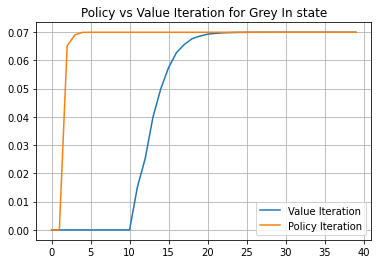

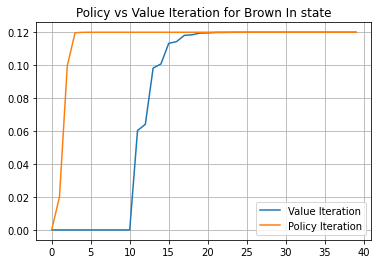

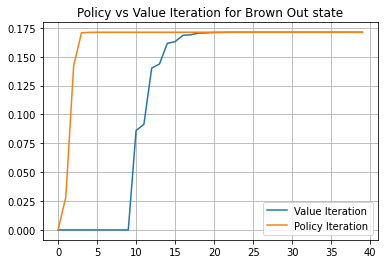

In [37]:
##### Value Iteration and Policy iteration graphs #######
import matplotlib.pyplot as plt
####### State Grey In ########
state_grey_in = [0,0]

vi_value_grey_in = [ extra_info_vi['Values_list'][i][state_grey_in[0]][state_grey_in[1]] for i in range(extra_info_vi['Steps']) ]
pi_value_grey_in = [ extra_info_pi['Values_list'][i][state_grey_in[0]][state_grey_in[1]] for i in range(extra_info_pi['Steps']) ]
indexes = [ i for i in range(extra_info_vi['Steps']) ]

for j in range(extra_info_vi['Steps'] - extra_info_pi['Steps']) :
  pi_value_grey_in.append(pi_value_grey_in[-1])

plt.plot(indexes,vi_value_grey_in,label='Value Iteration')
plt.plot(indexes,pi_value_grey_in,label='Policy Iteration')
plt.grid()
plt.legend()
plt.title('Policy vs Value Iteration for Grey In state')
plt.show()

#brown_in = [(9,7)]
#    grey_in = [(0,0)]
#    brown_out = [(1,7)]
####### State Brown In ########
state_brown_in = [9,7]

vi_value_brown_in = [ extra_info_vi['Values_list'][i][state_brown_in[0]][state_brown_in[1]] for i in range(extra_info_vi['Steps']) ]
pi_value_brown_in = [ extra_info_pi['Values_list'][i][state_brown_in[0]][state_brown_in[1]] for i in range(extra_info_pi['Steps']) ]

for j in range(extra_info_vi['Steps'] - extra_info_pi['Steps']) :
  pi_value_brown_in.append(pi_value_brown_in[-1])

plt.plot(indexes,vi_value_brown_in,label='Value Iteration')
plt.plot(indexes,pi_value_brown_in,label='Policy Iteration')
plt.grid()
plt.legend()
plt.title('Policy vs Value Iteration for Brown In state')
plt.show()

####### State Brown Out ########
state_brown_out = [1,7]

vi_value_brown_out = [ extra_info_vi['Values_list'][i][state_brown_out[0]][state_brown_out[1]] for i in range(extra_info_vi['Steps']) ]
pi_value_brown_out = [ extra_info_pi['Values_list'][i][state_brown_out[0]][state_brown_out[1]] for i in range(extra_info_pi['Steps']) ]

for j in range(extra_info_vi['Steps'] - extra_info_pi['Steps']) :
  pi_value_brown_out.append(pi_value_brown_out[-1])

plt.plot(indexes,vi_value_brown_out,label='Value Iteration')
plt.plot(indexes,pi_value_brown_out,label='Policy Iteration')
plt.grid()
plt.legend()
plt.title('Policy vs Value Iteration for Brown Out state')
plt.show()



## 2.b How changing $\lambda$ affecting TD Lambda

From the plots in 2.d we can see that the as we increase lambda, the final error decreases initially upto lamda = 0.5. However, once we further increase lamda, the error starts to increase again.

This could be owing to the bias-variance tradeoff which happens as we vary the value of lamda. So, initially as we increase lamda from 0, the bias of decreases. However, as we keep increasing lamda, the effect of increased variance starts to kick in and worsens the value function obtained.

## 2.c Policy iteration error curve
Plot error curve of $J_i$ vs iteration $i$ for policy iteration

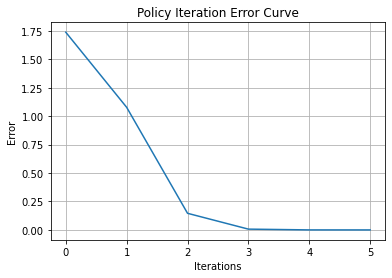

In [40]:
########### Policy iteration error curve #############

error_pi_list = [ np.sqrt(np.sum((extra_info_pi['Values_list'][i]-result_value_iteration['Values'])**2)/100)  for i in range(extra_info_pi['Steps'])]
indexes = [ i for i in range(extra_info_pi['Steps']) ]

plt.plot(indexes,error_pi_list)
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Policy Iteration Error Curve')
plt.show()


## 2.d TD Lamdba error curve
Plot error curve of $J_i$ vs iteration $i$ for TD Lambda for $\lambda = [0, 0.25, 0.5, 0.75, 1]$

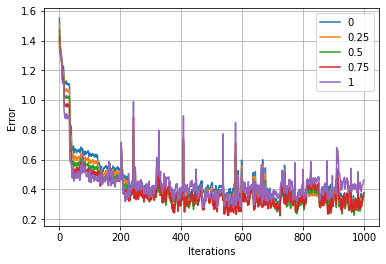

In [64]:
############# Error Curve across various values of lamda ###################
fig = plt.figure()
for lamda in [0,0.25,0.5,0.75,1] :

  error_td_lamda = [  np.sqrt(np.sum((i - result_value_iteration['Values'])**2)/100) for i in extra_info[lamda]['Values_list'] ]
  indexes = [i for i in range(1000)]

  plt.plot(indexes,error_td_lamda,label=str(lamda))
plt.legend()
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()


# Submit to AIcrowd 🚀

In [ ]:
!DATASET_PATH=$AICROWD_DATASET_PATH aicrowd notebook submit --no-verify -c iit-m-rl-assignment-2-gridworld -a assets

No jupyter lab module found. Using jupyter notebook.
Using notebook: /content/IITM_Assignment_2_Gridworld_Release.ipynb for submission...
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
